In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import sys
sys.path.insert(0, '../src/')
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from preprocessing import BagOfChords, MidiPathToDataFrameNorm, PreprocessMidiDataFrame

In [17]:
data_dir = Path('../maestro/maestro-v3.0.0/')

In [18]:
pipeline = Pipeline([
    ('loader', MidiPathToDataFrameNorm(data_dir)),
    ('BoC', BagOfChords(normalize=False)),
    ('pca', PCA(2))
])
df = pd.read_csv(data_dir / 'maestro-v3.0.0.csv')
sample = df.sample(100)

In [19]:
transformed_pca = pipeline.fit_transform(sample.midi_filename)

In [20]:
def get_color(composer):
    if composer == 'Franz Schubert':
        return 'r'
    if composer == 'Frédéric Chopin':
        return 'g'
    if composer == 'Franz Liszt':
        return 'b'
    if composer == 'Johann Sebastian Bach':
        return 'c'
    if composer == 'Ludwig van Beethoven':
        return 'm'
    return 'k'
sample.canonical_composer.value_counts()

canonical_composer
Frédéric Chopin                               14
Johann Sebastian Bach                         13
Franz Schubert                                12
Ludwig van Beethoven                          12
Franz Liszt                                   11
Sergei Rachmaninoff                            5
Joseph Haydn                                   4
Claude Debussy                                 4
Pyotr Ilyich Tchaikovsky                       2
Johannes Brahms                                2
Isaac Albéniz                                  2
Felix Mendelssohn                              2
Robert Schumann                                2
Muzio Clementi                                 2
Franz Schubert / Franz Liszt                   2
Johann Sebastian Bach / Franz Liszt            1
Wolfgang Amadeus Mozart                        1
George Frideric Handel                         1
Alban Berg                                     1
Domenico Scarlatti                             1
C

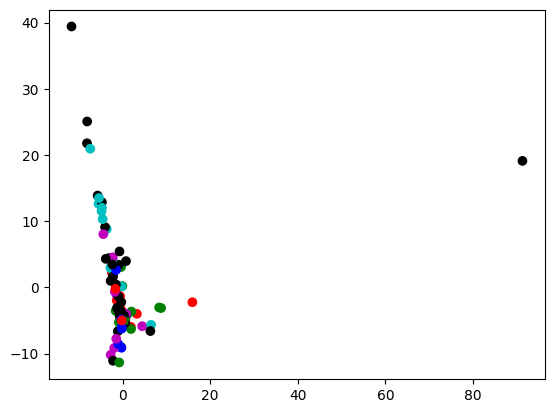

In [21]:
plt.scatter(transformed_pca[:, 0], transformed_pca[:, 1], c=[get_color(comp) for comp in sample.canonical_composer])
plt.show()

In [22]:
pipeline_isomap_boc = Pipeline([
    ('loader', MidiPathToDataFrameNorm(data_dir)),
    ('preproc', PreprocessMidiDataFrame()),
    ('BoC', BagOfChords(normalize=True)),
    ('isomap', Isomap(n_components=2, n_neighbors=5))
])

In [23]:
X_boc_iso = pipeline_isomap_boc.fit_transform(sample.midi_filename)

In [24]:
# True labels (e.g. composer names → categorical codes)
true_labels = sample.canonical_composer.astype("category").cat.codes

# Choose your features (e.g., BoN with PCA, or BoC with ISOMAP)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_boc_iso)

# Metrics
ari = adjusted_rand_score(true_labels, kmeans.labels_)
sil_score = silhouette_score(X_boc_iso, kmeans.labels_)

print(f"KMeans ARI: {ari:.4f}")
print(f"Silhouette Score: {sil_score:.4f}")


KMeans ARI: 0.0029
Silhouette Score: 0.7780


In [25]:
X_boc = pipeline_isomap_boc.fit_transform(sample.midi_filename)
y = sample.canonical_composer.astype("category").cat.codes

X_train, X_test, y_train, y_test = train_test_split(X_boc, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

acc = accuracy_score(y_test, clf.predict(X_test))
print(f"Classification accuracy (BoC): {acc:.4f}")


Classification accuracy (BoC): 0.1000


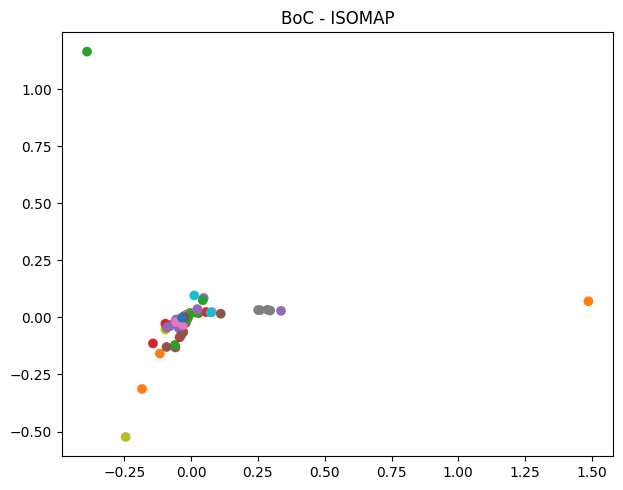

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.title("BoC - ISOMAP")
plt.scatter(X_boc_iso[:, 0], X_boc_iso[:, 1], c=true_labels, cmap='tab10')

plt.tight_layout()
plt.show()


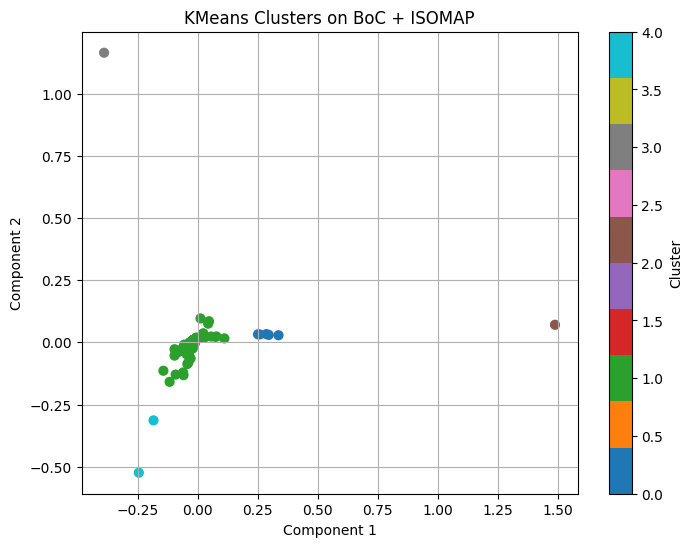

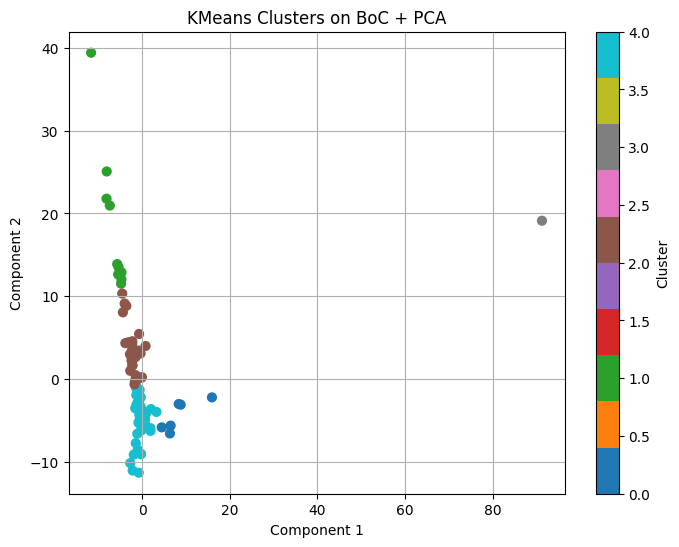

In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Fit KMeans
kmeans_boc = KMeans(n_clusters=5, random_state=42).fit(X_boc_iso)
labels_boc = kmeans_boc.labels_

# Plot clustering result (BoN)
plt.figure(figsize=(8, 6))
plt.scatter(X_boc_iso[:, 0], X_boc_iso[:, 1], c=labels_boc, cmap='tab10', s=40)
plt.title("KMeans Clusters on BoC + ISOMAP")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()

kmeans_boc = KMeans(n_clusters=5, random_state=42).fit(transformed_pca)
labels_boc = kmeans_boc.labels_

plt.figure(figsize=(8, 6))
plt.scatter(transformed_pca[:, 0], transformed_pca[:, 1], c=labels_boc, cmap='tab10', s=40)
plt.title("KMeans Clusters on BoC + PCA")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()


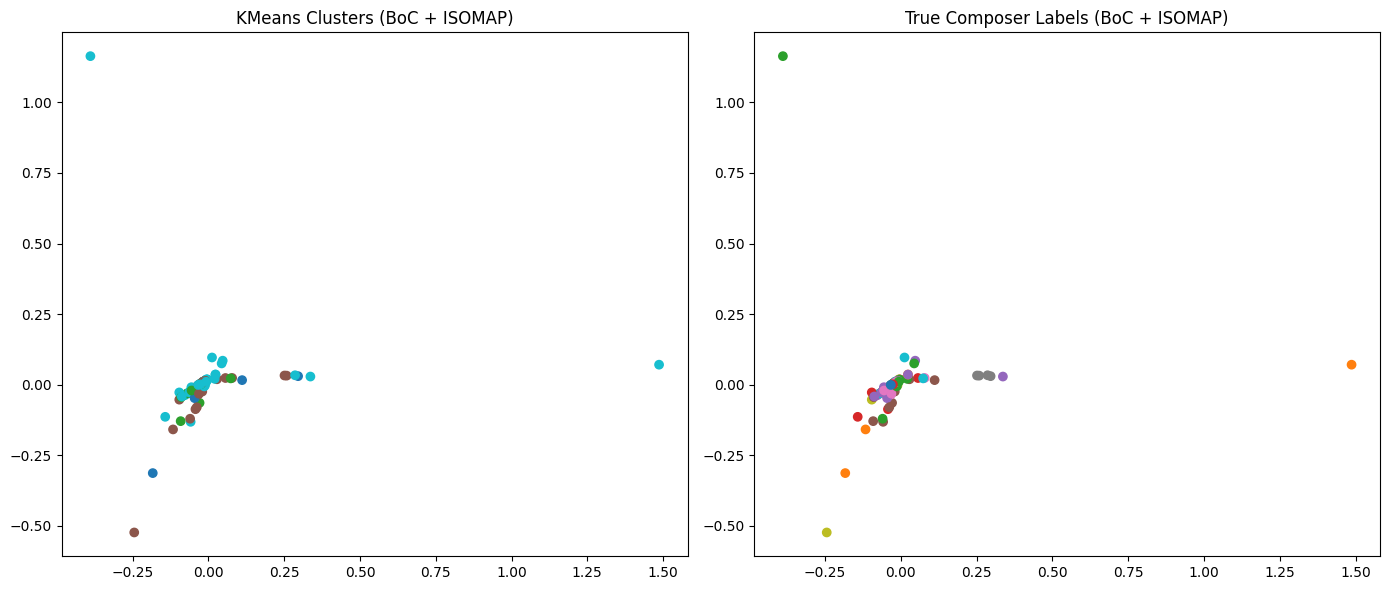

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(X_boc_iso[:, 0], X_boc_iso[:, 1], c=labels_boc, cmap='tab10')
axes[0].set_title("KMeans Clusters (BoC + ISOMAP)")

axes[1].scatter(X_boc_iso[:, 0], X_boc_iso[:, 1], c=true_labels, cmap='tab10')
axes[1].set_title("True Composer Labels (BoC + ISOMAP)")

plt.tight_layout()
plt.show()
